In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
import scanpy as sc
import anndata as an
import scipy
import sklearn
import gget

from importlib import reload
import utils as ut
import plotting as plt2

In [2]:
sc.settings.verbosity = 4

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/hsc_landscape.anndata.h5ad"

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()

adata

Memory usage: current 8.75 GB, difference +8.75 GB


AnnData object with n_obs × n_vars = 54347 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obs_names.nunique()

54347

# Subset the data

In [5]:
# Filter for the relevant cell types: Hematopoietic stem cells (HSC) and induced HSC (iHSC)
cell_types = ['HSC', 'iHSC']
pdf = adata[adata.obs['cell_type'].isin(cell_types), :].copy()  # Explicit copy for safety

print("Number of cells after cell type filtering:", pdf.shape[0])

# Further filter to include only datasets of interest: iHSC and young2_HSC
datasets = ['iHSC', 'young2_HSC']
pdf = pdf[pdf.obs['dataset'].isin(datasets), :]

print("Number of cells after dataset filtering:", pdf.shape[0])

sc.pp.filter_genes(pdf, min_cells=1) # remove genes only expressed in a single-cell

# Clean up cell IDs to remove "_iHSC" suffix
pdf.obs['cell_id'] = pdf.obs.index.str.replace("_iHSC", "")

# Display distribution of cells across the filtered datasets
print("Dataset distribution:")
print(pdf.obs['dataset'].value_counts()) 

pdf

Number of cells after cell type filtering: 14372
Number of cells after dataset filtering: 11817
Dataset distribution:
dataset
iHSC          8574
young2_HSC    3243
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 11817 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2', 'cell_id'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

# Add QC Variables

In [6]:
fpath = "../resources/qc_barcodes.csv"
codes = pd.read_csv(fpath)
codes['OG_cluster'] = codes['cluster_str']

# Column to exclude from suffixing
exclude_column = 'cell_id'

# Suffix to add
suffix = '_QC'

# Create new column names with suffixes
new_columns = [col + suffix if col != exclude_column else col for col in codes.columns]

# Rename columns in the DataFrame
codes.columns = new_columns

print(f"{pdf.obs.shape=} {codes.shape=}")


index = pdf.obs_names.copy()

pdf.obs = pd.merge(
    pdf.obs, 
    codes,
    how='left',
    left_on='cell_id',
    right_on='cell_id',
)

pdf.obs['OG_cluster_QC'] = pdf.obs['OG_cluster_QC'].fillna('HSC')
pdf.obs =  pdf.obs.set_index(index)

pdf.obs.head()

pdf.obs.shape=(11817, 11) codes.shape=(8563, 11)


,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,...,predicted_doublet_QC,cluster_str_QC,candidate_QC,CD34_QC,GATA2_QC,GFI1B_QC,FOS_QC,STAT5A_QC,REL_QC,OG_cluster_QC
AAACCCAAGGTTACCT_iHSC,6558.0,iHSC,iHSC,nan,12480,1,Reprogrammed Cells,D2,8.989130,4.937538,...,False,C1,False,True,True,True,False,True,False,C1
AAACCCAAGTTGAAGT_iHSC,5488.0,iHSC,iHSC,nan,12413,1,Reprogrammed Cells,D2,7.586400,4.889987,...,False,C1,False,False,False,False,False,False,False,C1
AAACCCAAGTTGTCGT_iHSC,4330.0,iHSC,iHSC,nan,11906,10,Reprogrammed Cells,D11,8.027761,3.311177,...,False,C4,False,False,True,False,False,False,False,C4
AAACCCACAGAAGCGT_iHSC,3442.0,iHSC,iHSC,nan,11861,10,Reprogrammed Cells,D11,8.584245,2.674468,...,False,C2,False,True,False,True,False,False,False,C2
AAACCCACAGGAGGTT_iHSC,14427.0,iHSC,iHSC,nan,13436,1,Reprogrammed Cells,D2,9.509144,4.923519,...,False,C1,False,True,True,False,False,False,False,C1


In [7]:
pdf.obs['cell_type'].value_counts()

cell_type
iHSC    8574
HSC     3243
Name: count, dtype: int64

# New PCA

Performing PCA dimensionality reduction...
computing PCA
    with n_comps=50
    finished (0:04:28)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


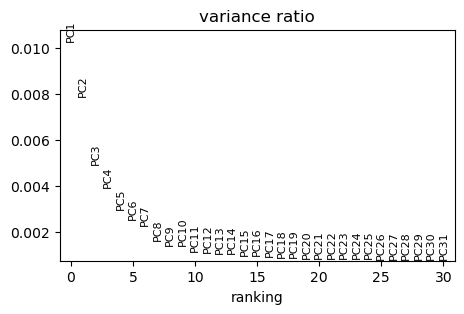

In [8]:
# PCA Analysis
print("Performing PCA dimensionality reduction...")
sc.pp.pca(
    pdf, 
    n_comps=50, 
    mask_var=None
)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 5, 3
sc.pl.pca_variance_ratio(
    pdf, 
)

# Distances

In [9]:
n_comps = 10

ihsc = pdf[pdf.obs['cell_type'] == 'iHSC', :].copy()
hsc = pdf[pdf.obs['cell_type'] == 'HSC', :].copy()

X_ihsc = ihsc.obsm['X_pca'][:, 0:n_comps]
X_hsc = hsc.obsm['X_pca'][:, 0:n_comps]

print(f"{X_ihsc.shape=}")
print(f"{X_hsc.shape=}")

X_ihsc.shape=(8574, 10)
X_hsc.shape=(3243, 10)


In [10]:
metric = 'cosine'
D = cdist(
    X_ihsc, 
    X_hsc, 
    metric=metric,
)

D = pd.DataFrame(
    D, 
    index=ihsc.obs_names,
    columns=hsc.obs_names,
)

print(f"{D.shape=}")

D.head()

D.shape=(8574, 3243)


,AAACAGCCAACCCTAA-3_young2_HSC,AAACAGCCATAGGCGA-3_young2_HSC,AAACATGCAGGCTGTT-3_young2_HSC,AAACCGCGTCCTTAGT-3_young2_HSC,AAACCGCGTCCTTTAA-3_young2_HSC,AAACCGGCAATAGCCC-3_young2_HSC,AAACCGGCAATGCCCG-3_young2_HSC,AAACCGGCAGCCTTGG-3_young2_HSC,AAACGCGCACCAACCG-2_young2_HSC,AAACGGATCCCTGACT-3_young2_HSC,...,TTTGTCCCAATAATCC-3_young2_HSC,TTTGTCCCACTTCATC-3_young2_HSC,TTTGTCCCAGTCTAGC-3_young2_HSC,TTTGTCCCATTGTCCT-3_young2_HSC,TTTGTCTAGCAAGGGT-2_young2_HSC,TTTGTGAAGCCTAATA-3_young2_HSC,TTTGTGGCACACCAAC-3_young2_HSC,TTTGTGGCATCTAGCA-2_young2_HSC,TTTGTGGCATTGGGAG-3_young2_HSC,TTTGTTGGTACGTTTC-3_young2_HSC
AAACCCAAGGTTACCT_iHSC,1.024103,1.111747,0.872196,1.415215,1.021673,1.414682,1.097115,1.485294,0.945665,1.264051,...,1.238117,1.303012,1.238413,1.455132,0.964724,1.378478,1.322744,0.992367,1.542565,1.096994
AAACCCAAGTTGAAGT_iHSC,0.893318,1.049703,0.835892,1.298800,1.078211,1.339204,1.083364,1.164171,0.797898,1.141824,...,1.192889,1.159785,1.069696,1.276749,0.939094,1.167239,1.231613,0.982172,1.353416,0.952484
AAACCCAAGTTGTCGT_iHSC,1.102940,1.121000,1.083815,1.031875,1.175266,0.976321,1.208265,0.959522,1.012753,0.731693,...,1.101070,1.026437,1.177146,0.992172,1.216636,1.006692,1.019361,1.229200,0.941284,0.985082
AAACCCACAGAAGCGT_iHSC,1.038908,1.089593,1.009519,0.998439,1.084982,1.077506,1.183006,1.125640,0.842979,0.623912,...,1.061930,1.154338,1.108283,1.127754,1.145681,1.013968,0.951103,1.270080,1.001923,0.959875
AAACCCACAGGAGGTT_iHSC,1.034434,1.024883,1.140263,1.223401,1.075851,1.085640,1.219693,1.164557,0.997346,1.406927,...,1.115269,1.198814,1.190621,1.228825,1.253305,1.061260,1.214926,1.315087,0.979931,1.115581


<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

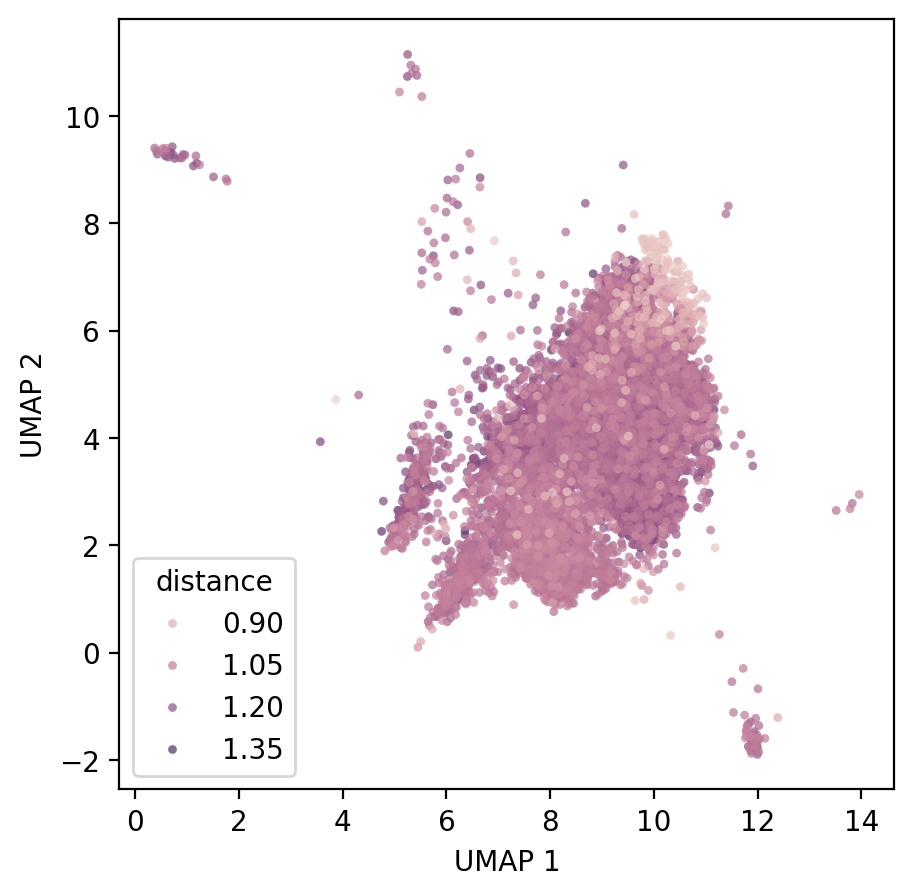

In [11]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

plot = ihsc.obs.copy()
plot['distance'] = D.median(axis=1)
sort_idx = np.argsort(plot['distance'].values)[::-1]

sns.scatterplot(
    data=plot.iloc[sort_idx],
    x='UMAP 1',
    y='UMAP 2',
    hue='distance',
    alpha=0.7,
    ec='none',
    s=10,
)

/tmp/ipykernel_2702872/2767338627.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,...,cluster_str_QC,candidate_QC,CD34_QC,GATA2_QC,GFI1B_QC,FOS_QC,STAT5A_QC,REL_QC,OG_cluster_QC,distance
AAACCCAAGGTTACCT_iHSC,6558.0,iHSC,iHSC,nan,12480,1,Reprogrammed Cells,D2,8.989130,4.937538,...,C1,False,True,True,True,False,True,False,C1,1.243430
GCACATATCTCTCGCA_iHSC,9145.0,iHSC,iHSC,nan,12891,11,Reprogrammed Cells,D12,8.815907,6.020735,...,C1,False,True,False,False,False,False,False,C1,1.131599
GCACATATCGTGTGAT_iHSC,4772.0,iHSC,iHSC,nan,12053,11,Reprogrammed Cells,D12,9.942209,6.505333,...,C1,False,False,False,False,False,True,False,C1,1.154343
GCACATATCCTTGACC_iHSC,15821.0,iHSC,iHSC,nan,13945,11,Reprogrammed Cells,D12,8.035115,5.347263,...,C1,False,True,True,False,True,False,False,C1,1.145661
GCACATAGTTTCAGAC_iHSC,3960.0,iHSC,iHSC,nan,11581,1,Reprogrammed Cells,D2,10.040021,4.140203,...,C1,False,False,False,False,False,False,False,C1,1.061776


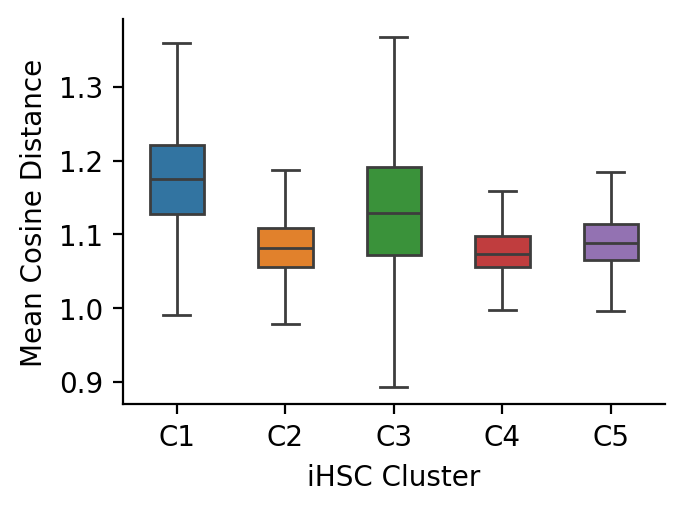

In [12]:
plot = ihsc.obs.copy()
plot['distance'] = D.median(axis=1)
plot = plot.sort_values(by='cluster_str_QC')

plot = plot[plot['cluster_str_QC'] != "C6"]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2.5

sns.boxplot(
    data=plot,
    x='cluster_str_QC',
    y='distance',
    width=0.5,
    showfliers=False,
    palette='tab10',
)

sns.despine()

plt.ylabel('Mean Cosine Distance')
plt.xlabel('iHSC Cluster')

plot.head()

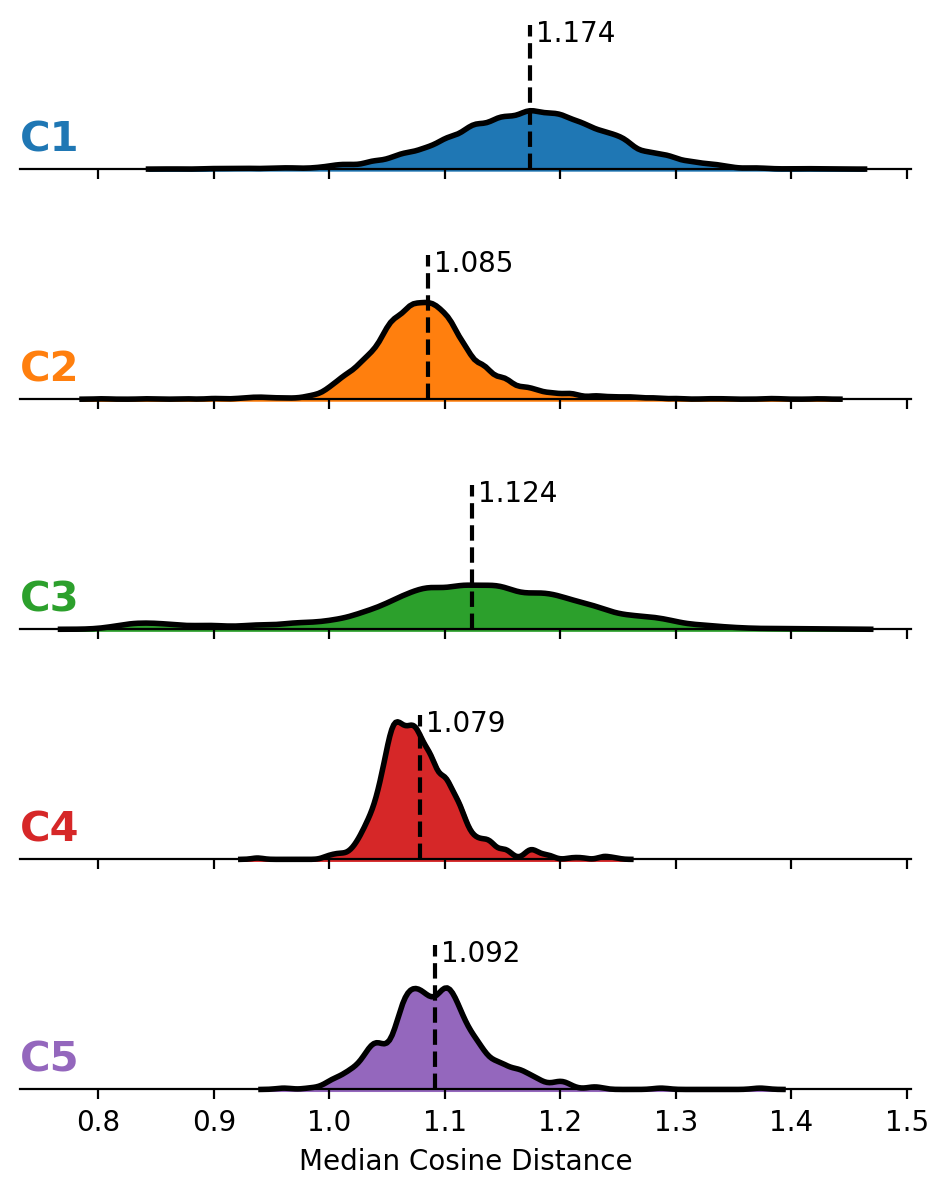

In [13]:
def create_facet_grid(df, x_col="x", group_col="g"):
    """
    Creates a faceted KDE plot for visualizing the distribution of a variable across groups.

    Args:
        df: The DataFrame containing the data.
        x_col: The name of the column containing the variable to plot.
        group_col: The name of the column containing the group labels.

    Returns:
        The FacetGrid object containing the plot.
    """
    g = sns.FacetGrid(
        df,
        row=group_col,
        hue=group_col,
        aspect=4.25,
        height=1.25,
        palette='tab10',
    )

    # Draw the densities
    g.map(
        sns.kdeplot, 
        x_col, 
        bw_adjust=0.5, 
        clip_on=False, 
        fill=True, 
        alpha=1, 
        linewidth=1.5,
    )
    
    g.map(
        sns.kdeplot, 
        x_col, 
        clip_on=False, 
        color="k", 
        lw=2, 
        bw_adjust=0.5,
    )
    
   # Calculate and add vertical lines for means
    def add_mean_line(x, **kwargs):
        ax = plt.gca()
        mean_value = df[df[group_col] == kwargs['label']][x_col].mean()
        ax.axvline(mean_value, color='k', linestyle='dashed', linewidth=1.5)
        
        
   # Calculate and add vertical lines for means
    def add_mean_annot(x,  **kwargs):
        ax = plt.gca()
        mean_value = df[df[group_col] == kwargs['label']][x_col].mean()
        ax.text(mean_value+0.005, 13, f"{mean_value:.3f}")

    g.map(add_mean_line, x_col)
    g.map(add_mean_annot, x_col)
    
    
    # Add labels
    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            0,
            0.2,
            label,
            fontweight="bold",
            fontsize=15,
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes,
        )

    g.map(label, x_col)


    g.set_titles("")
    g.set(yticks=[], ylabel="", xlabel="Median Cosine Distance")
    g.despine(left=True)

    return g


create_facet_grid(plot, x_col='distance', group_col='cluster_str_QC')

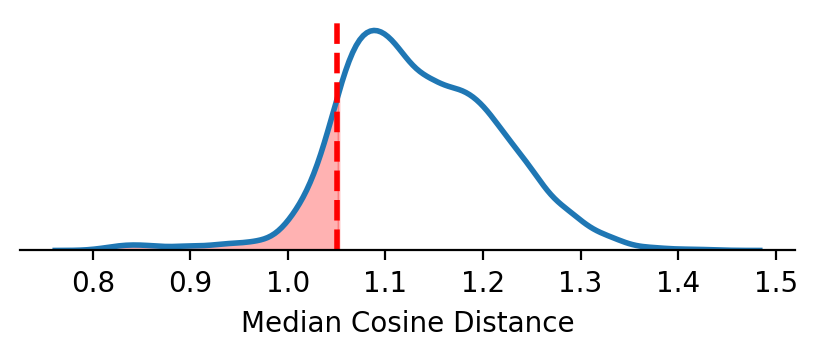

In [14]:
plot = ihsc.obs.copy()
plot['distance'] = D.median(axis=1)
plot = plot.sort_values(by='cluster_str_QC')

plot = plot[plot['cluster_str_QC'] != "C6"]


def plot_distance_kde(plot, x_col='distance', threshold=None, tail='right'):
    """Plots a kernel density estimation (KDE) plot of a given distance column in a DataFrame,
       with an optional vertical line at a specified threshold and shaded tail.

    Args:
        plot: The DataFrame containing the data.
        x_col: The name of the column containing the distance values (default: 'distance').
        threshold: The value at which to draw the vertical line and start shading. If None, no line or shading is applied (default: None).
        tail: The direction of the tail to shade. Can be 'right' or 'left' (default: 'right').
    """

    sns.kdeplot(data=plot, x=x_col, lw=2)

    if threshold is not None:
        # Draw the vertical line
        plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2)

        # Get the x and y values from the KDE plot
        kde_line = plt.gca().lines[0]
        x_data, y_data = kde_line.get_data()

        # Find the index of the point closest to the threshold
        idx = np.argmin(np.abs(x_data - threshold))

        # Fill the area under the curve for the specified tail
        if tail == 'right':
            plt.fill_between(x_data[idx-1:], y_data[idx-1:], color='red', alpha=0.3)
        elif tail == 'left':
            plt.fill_between(x_data[:idx+1], y_data[:idx+1], color='red', alpha=0.3)
            

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 1.5
THRESHOLD = 1.05
plot_distance_kde(
    plot, 
    x_col='distance', 
    threshold=THRESHOLD,
    tail='left',
)

plt.yticks([])
plt.ylabel("")
plt.xlabel("Median Cosine Distance")
sns.despine(left=True)


In [15]:
D.index.nunique()

8574

# Single Cell Plots

In [16]:
def drop_zero_sum_columns(df):
    """Drops columns from a DataFrame where the sum is zero.

    Args:
        df: The pandas DataFrame to process.

    Returns:
        The modified DataFrame with zero-sum columns removed.
    """

    # Calculate column sums
    column_sums = df.sum(axis=0)

    # Identify zero-sum columns (including all NaN)
    columns_to_drop = column_sums[(column_sums == 0) | (column_sums.isna())].index

    # Drop zero-sum columns
    df_updated = df.drop(columns_to_drop, axis=1)  

    return df_updated

# renormalize

In [17]:
def renormalize(adata):
    """Renormalizes an AnnData object by:

    1. Copying the existing 'X' matrix to a new layer called 'combat'.
    2. Replacing 'X' with the raw counts from 'raw_counts'.
    3. Filtering out genes expressed in only a single cell.
    4. Creating a new layer 'sqrt_norm' containing the square root of normalized counts.

    Args:
        adata: The AnnData object to renormalize.

    Returns:
        The renormalized AnnData object.
    """
    adata.layers['combat'] = adata.X.copy()
    adata.X = adata.layers['raw_counts'].copy()
    sc.pp.filter_genes(adata, min_cells=1) 
    adata.layers["sqrt_norm"] = np.sqrt(
        sc.pp.normalize_total(adata, inplace=False)["X"]
    )
    return adata
    
    
# renormalize    
hsc_renorm = renormalize(hsc)
ihsc_renorm = renormalize(ihsc)

# rejoin the normalized counts
hdf = an.concat(
    [hsc_renorm, ihsc_renorm],
    fill_value=0.0,
    join='inner', # switch to "outer" if we want genes not expressed in both datasets
)

sc.pp.filter_genes(hdf, min_cells=1) 

hdf

filtered out 3617 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)
filtered out 4005 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 11817 × 12027
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2', 'cell_id', 'predicted_doublet_QC', 'cluster_str_QC', 'candidate_QC', 'CD34_QC', 'GATA2_QC', 'GFI1B_QC', 'FOS_QC', 'STAT5A_QC', 'REL_QC', 'OG_cluster_QC'
    var: 'n_cells'
    obsm: 'X_pca', 'X_umap'
    layers: 'log_norm', 'raw_counts', 'combat', 'sqrt_norm'

In [18]:
def analyze_hdf_distances(hdf, D, threshold=1.09, layer='sqrt_norm', 
                          thresh_type='less', sample_size=50):
    """Analyzes distances within an hdf object and returns a dataframe.

    Args:
        hdf: The hdf object to analyze.
        D: The distance matrix.
        threshold: The threshold for considering distances as "close".
        thresh_type: either 'leq' or 'geq' for the different thresholding logic
        layer: The layer to extract from the hdf object.
        sample_size: The number of samples to take from each group.

    Returns:
        A dataframe containing the sampled data.
    """

    distances = D.median(axis=1)
    distances = distances[distances.index.isin(hdf.obs_names)]

    if thresh_type == 'leq':
        idx = distances[distances <= threshold].index
    else:
        idx = distances[distances >= threshold].index
        
    n = idx.shape[0]
    print(f"{threshold=} {n=}")

    df = pd.concat([
        hdf[idx, :].to_df(layer=layer).sample(sample_size),
        hdf[hdf.obs['cell_type'] == 'HSC', :].to_df(layer=layer).sample(sample_size),
    ], ignore_index=False,)

    print(f"{df.shape=}")

    return df

THRESHOLD = 1.05
df = analyze_hdf_distances(
    hdf, D, 
    threshold=THRESHOLD,
    thresh_type='leq', # get closest cells
)

df.head()

threshold=1.05 n=1126
df.shape=(100, 12027)


gene_name,A1BG,A2M,A2ML1,A3GALT2,AAAS,AADAT,AAGAB,AAK1,AAMDC,AAMP,...,ZSWIM7,ZSWIM8,ZSWIM9,ZW10,ZWILCH,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
CGAGTTATCCGGACGT_iHSC,0.000000,0.0,1.225412,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,1.225412,0.0,0.0,0.000000,0.0,1.225412,0.0,0.0
CGCATGGTCAACACGT_iHSC,1.356382,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,1.356382,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
GAATCGTAGGCTAGCA_iHSC,0.000000,0.0,0.000000,0.0,0.0,1.482157,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
CTACATTAGTTCCGTA_iHSC,0.607096,0.0,0.000000,0.0,0.0,0.607096,0.0,0.00000,0.0,0.858564,...,0.0,0.0,0.000000,0.0,0.0,0.607096,0.0,0.000000,0.0,0.0
ATGGTTGCAGCATACT_iHSC,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.67351,0.0,0.673510,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


threshold=1.08 n=2324
df.shape=(100, 12027)


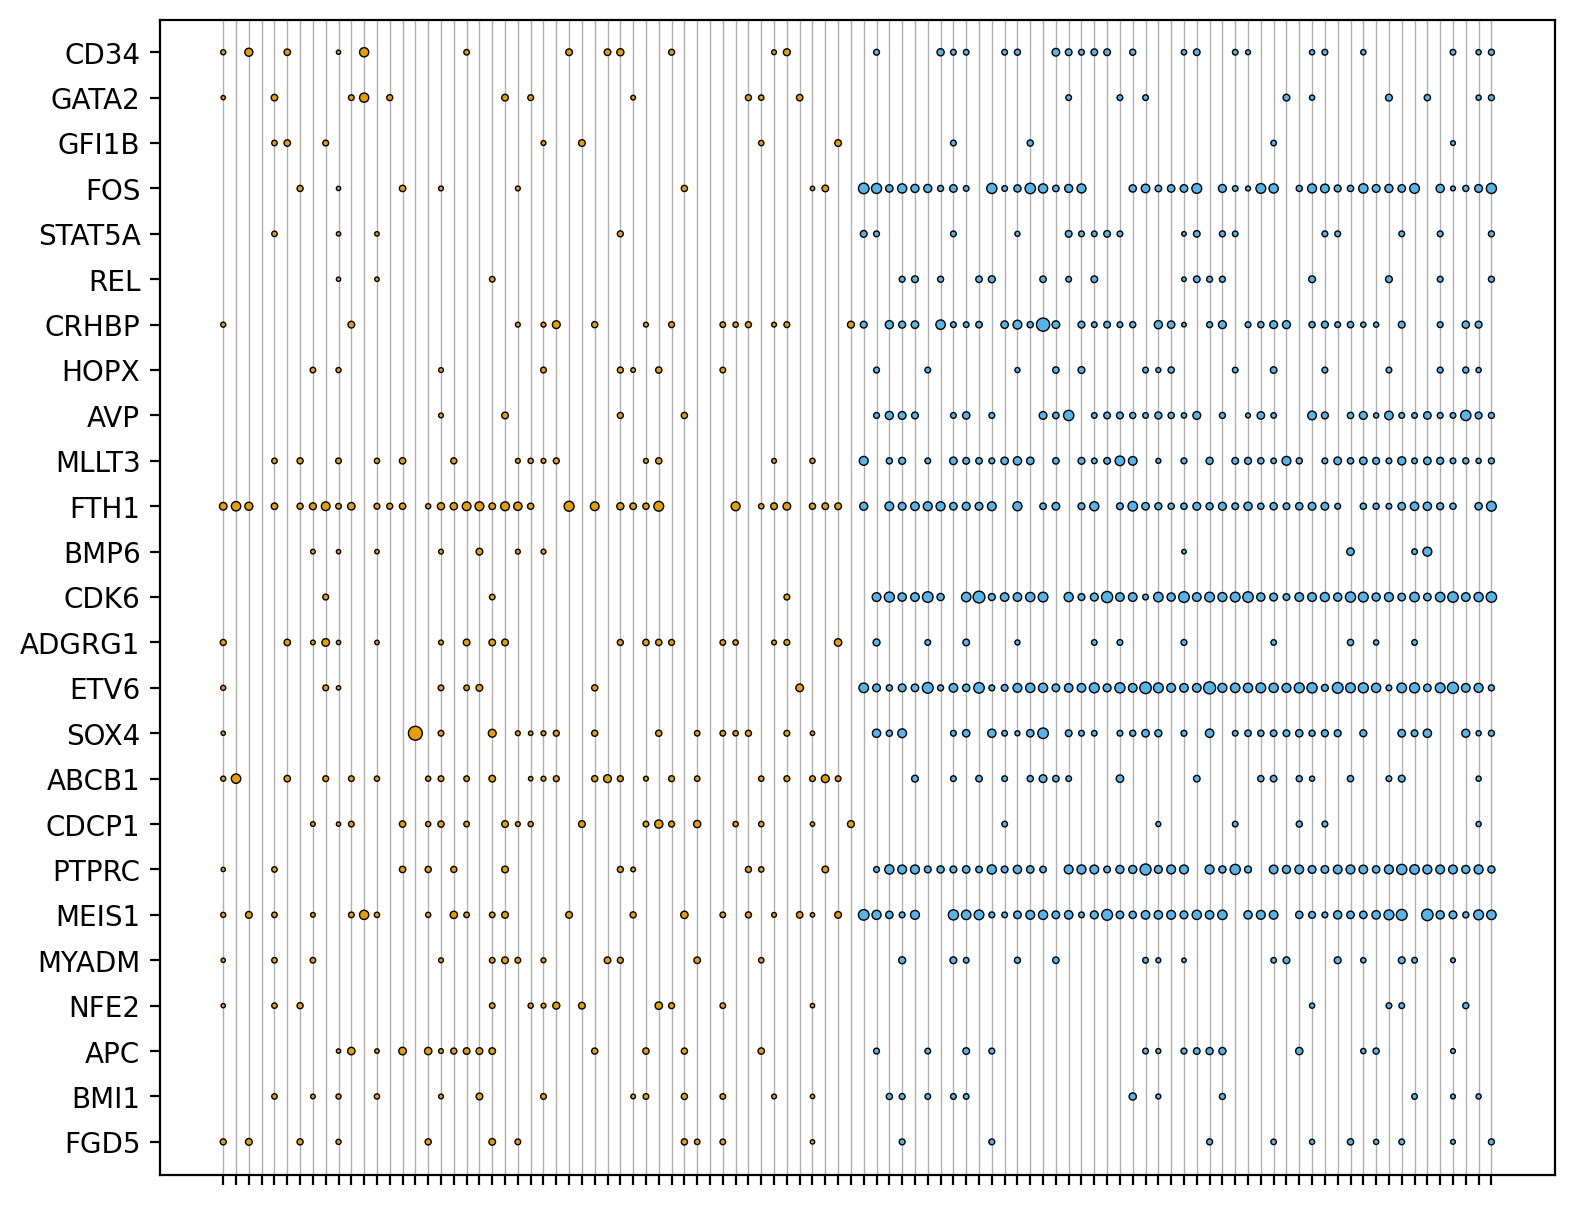

In [19]:
# gene_list = pdf.uns['go_annotations']['gene_name'].to_list()

THRESHOLD = 1.08
df = analyze_hdf_distances(
    hdf, D, 
    threshold=THRESHOLD,
     thresh_type='leq', # get closest cells
)

gene_list = [
    'CD34', 'GATA2', 'GFI1B',  'FOS', 'STAT5A', 'REL',
    'CRHBP', 'HOPX', 'AVP', 'MLLT3',
    'FTH1', 'BMP6',  'CDK6', 'ADGRG1', 'ETV6', 'SOX4',
    'ABCB1', 'CDCP1', 'PTPRC', 'MEIS1', 'MYADM', 'NFE2', 'APC', 'BMI1', 'FGD5',
    # 'MED12L', # 'RPS18', 'RPS4X', 'RPL10', 'RBPMS', 'HLF', 'MECOM', 'FLT3',
]
gene_list = [x for x in gene_list if x in df.columns]

plot = df[gene_list].reset_index(names='cell_id')
plot = pd.melt(plot, id_vars='cell_id')

plot['dataset'] = plot['cell_id'].apply(lambda x: x.split("_")[-1])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 9, (len(gene_list) * 0.3)

sns.scatterplot(
    data=plot,
    x='cell_id',
    y='gene_name',
    size='value',
    marker=".",
    hue='dataset',
    lw=0.5,
    ec='k',
    sizes=(0.0, 100),
    palette=["#E69F00", "#56B4E9"],
    zorder=5,
    legend=False,
)

plt.grid(axis='x', lw=0.5, zorder=0) 
# plt.xticks([])

plt.ylabel("")
plt.xlabel("")

plt.gca().tick_params(axis='x', labelsize=1, labelcolor='w')
plt.margins(y=0.03,)

plt.show()

# closest to closest

In [20]:
def find_n_min_indices_dataframe(df, n):
    """
    Finds the indices of the n smallest elements in a DataFrame.

    Args:
        df: The DataFrame.
        n: The number of minimum indices to find.

    Returns:
        A list of tuples containing the row and column indices
        of the n smallest elements.
    """

    # Flatten the DataFrame and get the indices of the n smallest values
    flat_indices = np.argpartition(df.values.ravel(), n)[:n]

    # Convert the flat indices back to row and column indices
    row_indices, col_indices = np.unravel_index(flat_indices, df.shape)

    # Create a list of tuples representing the indices
    return list(set(df.index[row_indices])), list(set(df.columns[col_indices]))


def sort_dataframe_like_clustermap(df):
    """Sorts a DataFrame similarly to how Seaborn's clustermap would.

    Args:
        df: The DataFrame to be sorted.

    Returns:
        The sorted DataFrame.
    """

    # Perform hierarchical clustering on rows and columns
    row_linkage = linkage(df.values, method='average')  # Adjust method if needed
    col_linkage = linkage(df.values.T, method='average')

    # Get the order of rows and columns from the dendrograms
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)

    # Reorder the DataFrame
    sorted_df = df.iloc[row_order, col_order]

    return sorted_df



row_idx, col_idx = find_n_min_indices_dataframe(D, 2000)
print(f"{D.loc[row_idx, col_idx].shape=}")

A = sort_dataframe_like_clustermap(D.loc[row_idx, col_idx])
print(f"{A.shape=}")

D.loc[row_idx, col_idx].shape=(239, 128)
A.shape=(239, 128)


([], [])

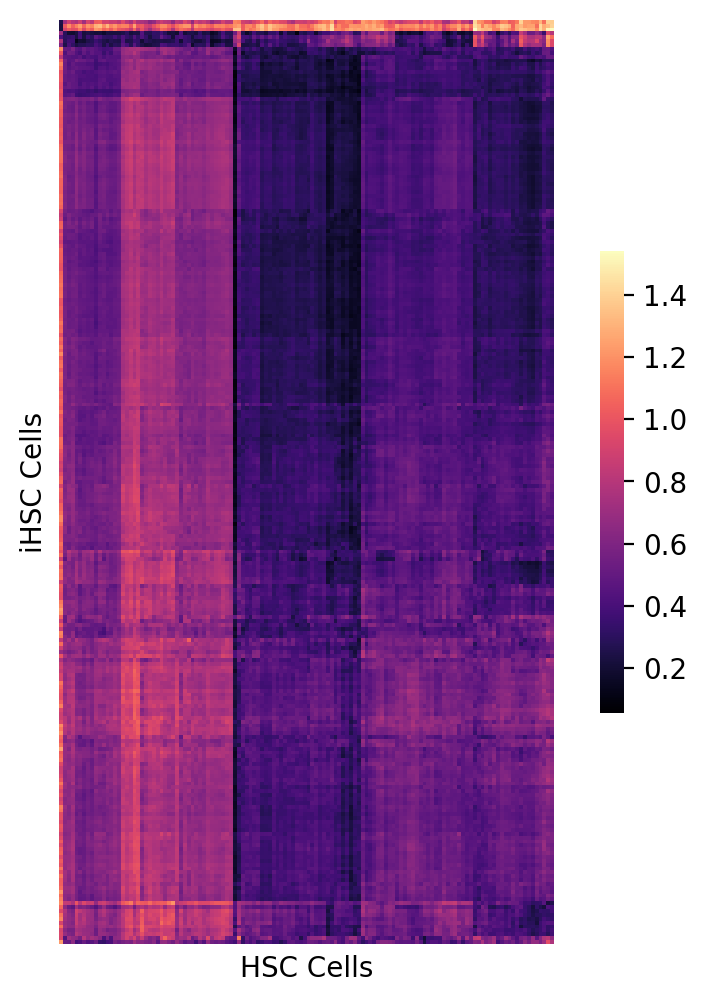

In [21]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(
    data=A,
    cbar_kws={'shrink' : 0.5},
    cmap='magma',
    square=True,
)

plt.xlabel("HSC Cells")
plt.ylabel("iHSC Cells")

plt.xticks([])
plt.yticks([])

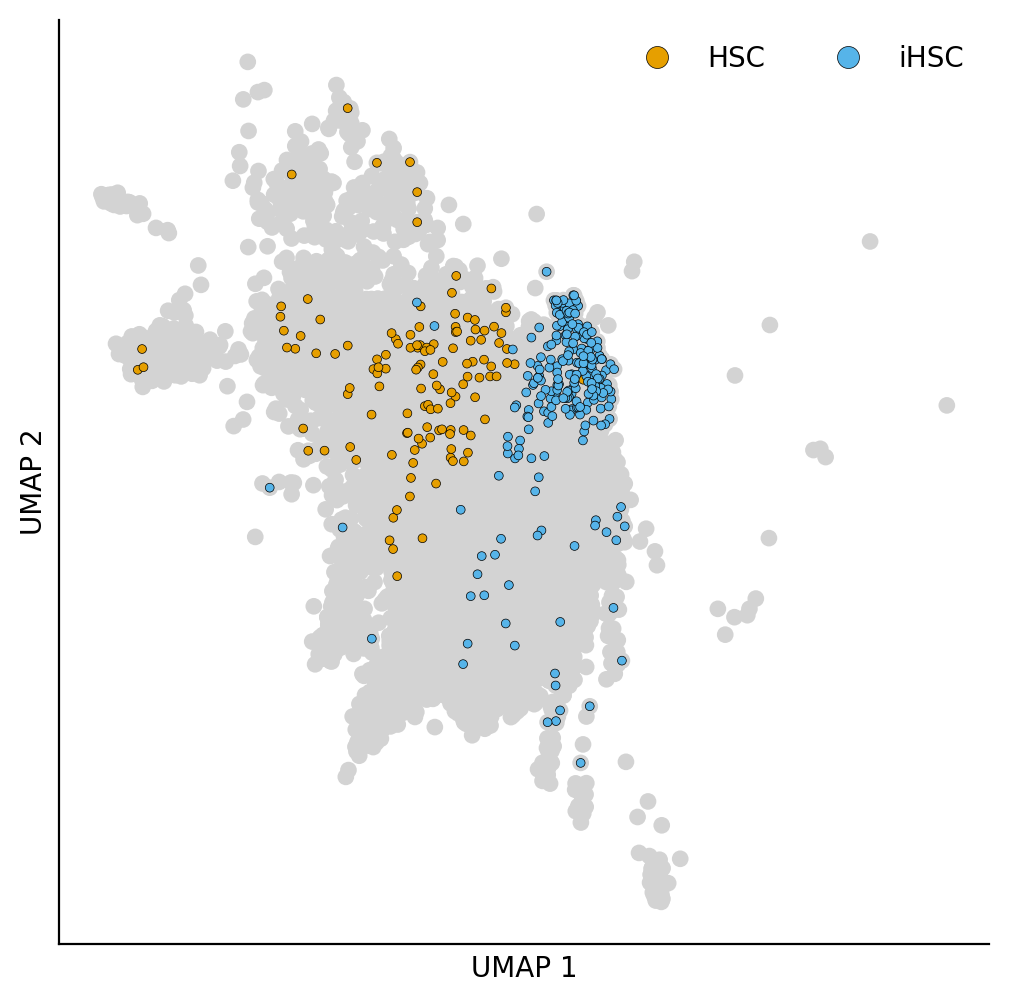

In [22]:
mask = col_idx + row_idx

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6


sns.scatterplot(
    data=hdf.obs,
    x='UMAP 1',
    y='UMAP 2',
    c='lightgrey',
    ec='none',
)

sns.scatterplot(
    data=hdf[mask, :].obs,
    x='UMAP 1',
    y='UMAP 2',
    hue='cell_type',
    ec='k',
    s=10,
    palette=["#E69F00", "#56B4E9"],
)


plt.xticks([])
plt.yticks([])

plt.gca().set_aspect('auto')

sns.move_legend(
    plt.gca(),
    loc='best',
    title="",
    frameon=False,
    markerscale=2.5,
    ncol=2,
)

sns.despine()

# non_differentially expressed genes

In [23]:
closest = hdf[row_idx + col_idx, :].copy()

sc.tl.rank_genes_groups(
    closest, 
    groupby="cell_type",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    layer='sqrt_norm',
    key_added='hsc_deg',
)

deg = sc.get.rank_genes_groups_df(
    closest, 
    group=None,
    key='hsc_deg',
)

deg.head()

ranking genes


... storing 'cluster_str_QC' as categorical
... storing 'OG_cluster_QC' as categorical


    consider 'cell_type' groups:
    with sizes: [128 239]
    finished: added to `.uns['hsc_deg']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,HSC,RPL32,15.792128,35.215366,3.524857e-56,2.619238e-53,1.0,0.000000
1,HSC,RPL18,15.792128,34.274418,3.524857e-56,2.619238e-53,1.0,0.000000
2,HSC,RPL28,15.792128,35.445683,3.524857e-56,2.619238e-53,1.0,0.000000
3,HSC,RPL9,15.792128,33.972160,3.524857e-56,2.619238e-53,1.0,0.000000
4,HSC,RPS12,15.792128,13.621265,3.524857e-56,2.619238e-53,1.0,0.004184


In [24]:
df = deg.copy()

pvals_adj = 0.01
logfoldchanges = 1.0

pang = adata.uns['panglaodb']
gene_list = adata.uns['go_annotations']['gene_name'].to_list() + list(pang[pang['cell_type'] == 'Hematopoietic stem cells']['gene_name'].unique())

df = df[df['pvals_adj'] > pvals_adj] # not statistically different
df = df[df['logfoldchanges'].abs() < logfoldchanges]
df = df[df['names'].isin(gene_list)]

print(f"{df.shape=}")

df.head()

df.shape=(46, 8)


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
2006,HSC,ABCB1,2.039576,0.959371,0.041393,0.213936,0.195312,0.058577
2412,HSC,APC,1.653961,0.358567,0.098135,0.417058,0.171875,0.058577
2869,HSC,ADGRG1,1.349393,0.675291,0.177211,0.638357,0.125000,0.037657
3129,HSC,NOTCH2,1.167684,-0.139191,0.242934,0.798080,0.164062,0.079498
3880,HSC,SH2B3,0.830078,0.348078,0.406495,1.000000,0.093750,0.037657


edf.shape=(367, 34)


,cell_id,gene_name,value,cell_type
0,CCATCACAGTCCTACA_iHSC,ABCB1,0.000000,iHSC
1,ATGTCTTTCATAGCAC_iHSC,ABCB1,0.000000,iHSC
2,CTAGACATCACCACAA_iHSC,ABCB1,2.180000,iHSC
3,AAGATAGCACTGATTG_iHSC,ABCB1,0.000000,iHSC
4,AGCCACGAGATGGCGT_iHSC,ABCB1,0.000000,iHSC
...,...,...,...,...
12473,CGGCTCACACAAGCCT-3_young2_HSC,ABCB1,1.241501,HSC
12474,ATGGTGCGTACCGTTT-3_young2_HSC,ABCB1,1.292568,HSC
12475,GAGCGAAGTTTAACCC-3_young2_HSC,ABCB1,0.000000,HSC
12476,TGAGCCGGTTTAACGG-3_young2_HSC,ABCB1,0.000000,HSC


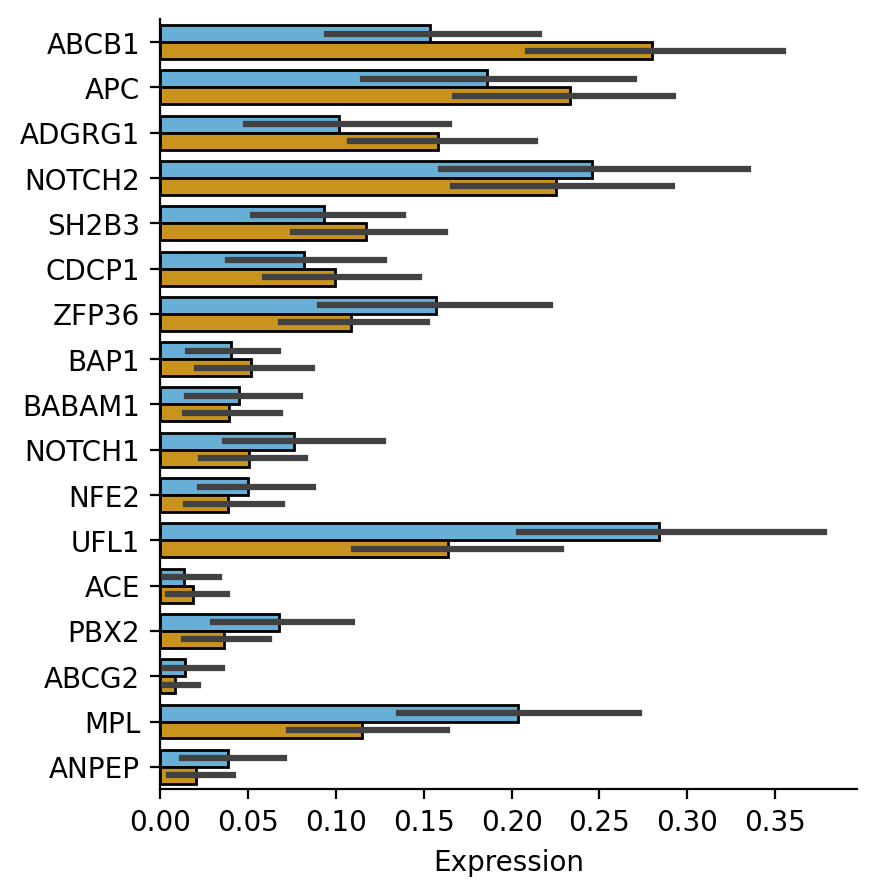

In [25]:
reload(ut)

edf = closest[:, df['names'].values].to_df(layer='sqrt_norm')

edf = ut.drop_zero_sum_columns(edf)
print(f"{edf.shape=}")

edf = edf.reset_index(names='cell_id')
edf = pd.melt(edf, id_vars='cell_id')
edf['cell_type'] = edf['cell_id'].apply(lambda x: x.split("_")[-1])


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4.5, 5


sns.barplot(
    data=edf, 
    y='gene_name',
    x='value',
    ec='k',
    width=0.75,
    hue='cell_type',
    palette=["#56B4E9", "#E69F00"],
    legend=False,
)

plt.ylabel("")
plt.xlabel("Expression")


# sns.move_legend(
#     plt.gca(),
#     loc='best',
#     title="",
#     frameon=False,
#     markerscale=2.5,
#     bbox_to_anchor=(1.2, 1)
# )

sns.despine()

edf

In [26]:
database = 'ontology'
gsea = gget.enrichr(
    edf['gene_name'].unique(), 
    database=database,
)

gsea[['path_name', 'adj_p_val', 'overlapping_genes']].head(15)

Thu Aug  8 16:36:41 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,regulation of growth rate (GO:0040009),0.002112,"[NOTCH2, NOTCH1]"
1,xenobiotic transport across blood-brain barrie...,0.002112,"[ABCB1, ABCG2]"
2,negative regulation of cell population prolife...,0.002112,"[ADGRG1, NOTCH1, APC, SH2B3, BAP1]"
3,positive regulation of Ras protein signal tran...,0.002546,"[NOTCH2, ADGRG1, NOTCH1]"
4,regulation of cell population proliferation (G...,0.002636,"[UFL1, ADGRG1, NOTCH1, APC, SH2B3, BAP1]"
5,hematopoietic stem cell differentiation (GO:00...,0.002636,"[UFL1, ACE]"
6,Notch signaling involved in heart development ...,0.002760,"[NOTCH2, NOTCH1]"
7,transepithelial transport (GO:0070633),0.004121,"[ABCB1, ABCG2]"
8,negative regulation of cellular process (GO:00...,0.004121,"[ADGRG1, NOTCH1, APC, SH2B3, BAP1]"
9,pulmonary valve morphogenesis (GO:0003184),0.004121,"[NOTCH2, NOTCH1]"


In [27]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
layer = 'sqrt_norm'

row_idx, col_idx = find_n_min_indices_dataframe(D, 2000)

df = hdf[row_idx + col_idx, :].to_df(layer=layer)
df.head()

# Furthest cells

In [ ]:
# gene_list = pdf.uns['go_annotations']['gene_name'].to_list()

THRESHOLD = 1.3
df = analyze_hdf_distances(
    hdf, D, 
    threshold=THRESHOLD,
     thresh_type='geq', # get closest cells
)

gene_list = [
    'CD34', 'GATA2', 'GFI1B',  'FOS', 'STAT5A', 'REL',
    'CRHBP', 'HOPX', 'AVP', 'MLLT3',
    'FTH1', 'BMP6',  'CDK6', 'ADGRG1', 'ETV6', 'SOX4',
    'ABCB1', 'CDCP1', 'PTPRC', 'MEIS1', 'MYADM', 'NFE2',
    # 'MED12L', # 'RPS18', 'RPS4X', 'RPL10', 'RBPMS', 'HLF', 'MECOM', 'FLT3',
]

gene_list = [x for x in gene_list if x in df.columns]

plot = df[gene_list].reset_index(names='cell_id')
plot = pd.melt(plot, id_vars='cell_id')

plot['dataset'] = plot['cell_id'].apply(lambda x: x.split("_")[-1])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 9, (len(gene_list) * 0.3)

sns.scatterplot(
    data=plot,
    x='cell_id',
    y='gene_name',
    size='value',
    marker=".",
    hue='dataset',
    lw=0.5,
    ec='k',
    sizes=(0.0, 100),
    palette=["#E69F00", "#56B4E9"],
    zorder=5,
    legend=False,
)

plt.grid(axis='x', lw=0.5, zorder=0) 
# plt.xticks([])

plt.ylabel("")
plt.xlabel("")

plt.gca().tick_params(axis='x', labelsize=1, labelcolor='w')
plt.margins(y=0.1,)

plt.show()

# Most similar genes

In [ ]:

THRESHOLD = 1.1
df = analyze_hdf_distances(
    hdf, D, 
    threshold=THRESHOLD,
     thresh_type='leq', # get closest cells
)

# gene_list = np.random.choice(df.columns, 20, replace=False)
# gene_list = df.median(axis=0).sort_values(ascending=False).head(15).index

pang = pdf.uns['panglaodb']
pang = pang[pang['cell_type'] == 'Hematopoietic stem cells']
gene_list = list(pang['gene_name'].unique())
gene_list = [x for x in gene_list if x in df.columns]

plot = df[gene_list].reset_index(names='cell_id')
plot = pd.melt(plot, id_vars='cell_id')

plot['dataset'] = plot['cell_id'].apply(lambda x: x.split("_")[-1])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 9, (len(gene_list) * 0.3)

sns.scatterplot(
    data=plot,
    x='cell_id',
    y='gene_name',
    size='value',
    marker=".",
    hue='dataset',
    lw=0.5,
    ec='k',
    sizes=(0.0, 100),
    palette=["#E69F00", "#56B4E9"],
    zorder=5,
    legend=False,
)

plt.grid(axis='x', lw=0.5, zorder=0) 
# plt.xticks([])

plt.ylabel("")
plt.xlabel("")

plt.gca().tick_params(axis='x', labelsize=1, labelcolor='w')
plt.margins(y=0.1,)

plt.show()

In [ ]:
pang = pdf.uns['panglaodb']
pang = pang[pang['cell_type'] == 'Hematopoietic stem cells']
pang.head()

In [ ]:
pang['cell_type'].unique()

In [ ]:
df.median(axis=0).sort_values(ascending=False).head(15).index

In [ ]:
break

In [ ]:
break

# Reprocess

In [ ]:
# def renormalize(adata):
#     adata.layers['combat'] = adata.X.copy()
#     adata.X = adata.layers['raw_counts'].copy()
    
#     sc.pp.filter_genes(adata, min_cells=1) # remove genes only expressed in a single-cell
    
#     adata.layers["sqrt_norm"] = np.sqrt(
#         sc.pp.normalize_total(adata, inplace=False)["X"]
#     )    
#     return adata
    
    
# # renormalize    
# hsc_renorm = renormalize(hsc)
# ihsc_renorm = renormalize(ihsc)

# # Concatenate the objects
# hdf = hsc_renorm.concatenate(
#     ihsc_renorm,
#     batch_key="",
#     index_unique=None,
# )

# # Optionally, harmonize variable (gene) names
# hdf.var_names_make_unique()

# # regress out batch effects
# sc.pp.regress_out(
#     hdf, 
#     keys='dataset', 
#     layer="sqrt_norm",
# )

# hdf
    

In [ ]:
# sc.pp.filter_genes(hdf, min_cells=2) # remove genes only expressed in a single-cell
# sc.pp.filter_cells(hdf, min_genes=200) # remove genes only expressed in a single-cell

# sc.pp.calculate_qc_metrics(
#     hdf, 
#     inplace=True,
# )

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 5

# sc.pl.violin(
#         hdf,
#         ["n_genes_by_counts", "total_counts"],
#         groupby='dataset',
#         jitter=0.4,
#         multi_panel=True,
#     )

In [ ]:
# hdf.obs_names[:10]

In [ ]:
plot['cell_id'].nunique()

In [ ]:
plot['cell_id'].head(35)

In [ ]:
sns.boxplot(
    plot,
     x='dataset',
    y='value'
)

In [ ]:
pdf

In [ ]:
break

# Recluster

In [ ]:
np.dot(D, D.T).shape

In [ ]:
# distance matrix

D_sort = D.copy()
sorted_idx = ihsc.obs.sort_values(by='cluster_str_QC').index
D_sort = D_sort.reindex(sorted_idx)

DDT = np.dot(D_sort, D_sort.T)
plt.imshow(DDT)

In [ ]:
# # distance matrix

# D_sort = D.copy()
# sorted_idx = ihsc.obs.sort_values(by='cluster_str_QC').index
# D_sort = D_sort.reindex(sorted_idx)


# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 10, 7

# plt.imshow(
#     scipy.stats.zscore(D_sort, axis=0),
#     cmap='plasma',
# )



# plot = ihsc.obs.copy()
# plot['distance'] = D.median(axis=1)

# D.head()

In [ ]:
ihsc.obs.head()

In [ ]:
break

In [ ]:
# # least squares
# A = ihsc.X.todense()
# b = D.mean(axis=1).to_numpy()

# print(f"{A.shape=} {b.shape=}")

# x, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)
# print(f"{rank=} {x.shape=} {residuals.shape=}")

# Distance Matrix

In [ ]:
D.head()

In [ ]:
break

In [ ]:
# plot = ihsc.obs.copy()
# plot['distance'] = D.median(axis=1)

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 1.5, 2

# sns.boxplot(
#     data=plot,
#     x='candidate_QC',
#     y='distance',
#     showfliers=False,
# )

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.kdeplot(
    data=plot,
    x='distance',
    hue='candidate_QC',
    common_norm=False,
    
)

In [ ]:
plot.head()

In [ ]:
break

In [ ]:
ihsc

In [ ]:
break

# Filter out FB-like cells
cluster C1 and C3 of the iHSC data are not considered here

In [ ]:
pdf = pdf[pdf.obs['OG_cluster_QC'].isin(['HSC', 'C2', 'C4', 'C5']), :]
pdf

In [ ]:
# Highly variable
sc.pp.highly_variable_genes(
    pdf,
    n_top_genes=100,
    batch_key='dataset',
)

pdf.var['highly_variable'].value_counts()

# PCA and clustering 

In [ ]:
# PCA Analysis
print("Performing PCA dimensionality reduction...")
sc.pp.pca(
    pdf, 
    n_comps=50, 
    mask_var='hsc_cluster_genes',
)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 5, 3
sc.pl.pca_variance_ratio(
    pdf, 
)

In [ ]:
# break

# Nice plots